In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import  caffe
import os
import lmdb
from random import shuffle
from scipy.misc import imread
from pprint import pprint

In [11]:
n_people = 38
n_train_person = 35

X_train = []
y_train = []
X_test = []
y_test = []

def is_legal_filename(fn):
    return len(fn) >= 24 and fn.endswith('.pgm')

for p in range(n_people):
    people_id = p + 1 + (p >= 13) * 1
    dirname = 'CroppedYale/yaleB{:02}/'.format(people_id)
    filenames = [x for x in os.listdir(dirname) if is_legal_filename(x)]
    shuffle(filenames)
            
    for i, filename in enumerate(filenames[:n_train_person]):
        img = imread(dirname + filename, mode='F').ravel()
        X_train.append(img)
        y_train.append(p)
    
    for i, filename in enumerate(filenames[n_train_person:]):
        img = imread(dirname + filename, mode='F').ravel()
        X_test.append(img)
        y_test.append(p)
        
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.int32)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.int32)

In [12]:
def write_lmdb(dirname, X, y):
    env = lmdb.open(dirname, map_size=(2**40))
#     indices = np.arange(X.shape[0])
    indices = np.random.permutation(X.shape[0])

    with env.begin(write=True) as txn:
        # txn is a Transaction object
        for i, x, y in zip(indices, X, y):
            datum = caffe.proto.caffe_pb2.Datum()
            datum.channels = 1
            datum.height = 192
            datum.width = 168
            datum.data = x.tobytes()  # or .tostring() if numpy < 1.9
            datum.label = int(y)
            txn.put('{:08}'.format(i), datum.SerializeToString())

!rm -rf ./train_lmdb
!rm -rf ./test_lmdb
write_lmdb('./train_lmdb', X_train, y_train)
write_lmdb('./test_lmdb', X_test, y_test)


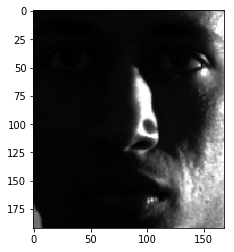

11


In [13]:
env = lmdb.open('./train_lmdb', readonly=True)
with env.begin() as txn:
    datum = caffe.proto.caffe_pb2.Datum()
    datum.ParseFromString(txn.get(b'00000000'))
    img = np.fromstring(datum.data, dtype=np.float32).reshape(192, 168)
    label = datum.label
    
    plt.imshow(img, cmap="gray")
    plt.show()
    print(label)